In [1]:
import os, sys 
import torch 
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import IPython.display as ipd
from argparse import Namespace
import torch.nn as nn 
import torch.nn.functional as F
import librosa
import argparse
import scipy 
from IPython.display import Audio
import numpy as np
from matplotlib.pyplot import cm
from tqdm import tqdm
import time

sys.path.append("../../")

In [2]:
from __config__ import *
import attentional_control.dnn.models.simplified_tasnet as simplified_tasnet
import attentional_control.dnn.losses.sisdr as sisdr_lib

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
torch.cuda.empty_cache()

In [3]:
def get_model_requirements(model, opt,
                           number_of_batches=10,
                           batch_size=1,
                           n_sources=2,
                           time_length=32000,
                           fs=8000,
                           to_GPU=True):
    
    per_sec_c = number_of_batches * batch_size * n_sources * (time_length / (1. * fs))
    
    def random_input_gen(number_of_batches, batch_size, n_sources, time_length):
        for i in range(number_of_batches):
            sources = torch.rand(batch_size, n_sources, time_length)
            mixture = torch.sum(sources, dim=1)
            yield mixture, sources
            
    requirements_dict = {
        'Fetching': 0.,
        'Moving to GPU': 0.,
        'Train Forward': 0.,
        'Eval Forward': 0.,
        'Loss Computation': 0.,
        'Backward': 0.,
        'Parameters': 0.,
    }

    numparams = 0
    for f in model.parameters():
        if f.requires_grad:
            numparams += f.numel()
    requirements_dict['Parameters'] = numparams
            
    if to_GPU:
        model = model.cuda()

    sisdr_loss = sisdr_lib.PermInvariantSISDR(batch_size=batch_size,
                                              n_sources=n_sources,
                                              zero_mean=True,
                                              backward_loss=False,
                                              improvement=True,
                                              return_individual_results=False)

    train_gen = random_input_gen(number_of_batches, batch_size, n_sources, time_length)
    test_gen = random_input_gen(number_of_batches, batch_size, n_sources, time_length)

    
    model.train()

    for data in tqdm(train_gen, desc='Training'):
        st = time.time()
        opt.zero_grad()
        m1wavs = data[0].unsqueeze(1)
        clean_wavs = data[-1]
        requirements_dict['Fetching'] += (time.time() - st) / per_sec_c
        
        st = time.time()
        if to_GPU:
            m1wavs = m1wavs.cuda()
            clean_wavs = clean_wavs.cuda()
        requirements_dict['Moving to GPU'] += (time.time() - st) / per_sec_c
        
        st = time.time()
        rec_sources_wavs = model(m1wavs)
        requirements_dict['Train Forward'] += (time.time() - st) / per_sec_c

        st = time.time()
        l = sisdr_loss(rec_sources_wavs, clean_wavs, initial_mixtures=m1wavs)
        requirements_dict['Loss Computation'] += (time.time() - st) / per_sec_c
        
        st = time.time()
        l.backward()
        opt.step()
        requirements_dict['Backward'] += (time.time() - st) / per_sec_c
        
        
    del model
    return requirements_dict
    


In [4]:
computational_results = {}

for P, R in [(3, 4), (3, 1), (3, 2), (61, 4), (61, 2), (61, 1)]:
    for to_GPU in [False, True]:
        hparams = {
            'B': 256,
            'H': 512,
            'P': P,
            'R': R,
            'X': 8,
            'L': 21,
            'N': 64,
            'S': 2,
            'lr': 0.001,
        }

        model = simplified_tasnet.TDCN(
            B=hparams['B'],
            H=hparams['H'],
            P=hparams['P'],
            R=hparams['R'],
            X=hparams['X'],
            L=hparams['L'],
            N=hparams['N'],
            S=hparams['S'])

        opt = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

        reqs = get_model_requirements(model, opt, 
                                      number_of_batches=10,
                                      batch_size=1,
                                      n_sources=2,
                                      time_length=32000,
                                      to_GPU=to_GPU)
        
        computational_results['P_{}_R_{}_GPU_{}'.format(P, R, to_GPU)] = reqs

Training: 10it [06:54, 41.47s/it]
Training: 10it [00:02,  4.83it/s]
Training: 10it [01:20,  8.09s/it]
Training: 10it [00:00, 15.00it/s]
Training: 10it [02:39, 15.90s/it]
Training: 10it [00:01,  8.25it/s]
Training: 10it [07:15, 43.58s/it]
Training: 10it [00:02,  4.40it/s]
Training: 10it [03:31, 21.18s/it]
Training: 10it [00:01,  8.24it/s]
Training: 10it [01:48, 10.81s/it]
Training: 10it [00:00, 14.97it/s]


In [92]:
print(computational_results)

{'P_3_R_4_GPU_False': {'Fetching': 0.0005796760320663453, 'Moving to GPU': 1.1920928955078124e-07, 'Train Forward': 0.24835759103298186, 'Eval Forward': 0.0, 'Loss Computation': 0.003285861015319824, 'Backward': 4.931475996971131, 'Parameters': 8581894}, 'P_3_R_4_GPU_True': {'Fetching': 0.00022522509098052976, 'Moving to GPU': 1.5369057655334474e-05, 'Train Forward': 0.006712120771408082, 'Eval Forward': 0.0, 'Loss Computation': 0.00025042295455932615, 'Backward': 0.01847699582576752, 'Parameters': 8581894}, 'P_3_R_1_GPU_False': {'Fetching': 0.00016832351684570312, 'Moving to GPU': 1.0728836059570314e-07, 'Train Forward': 0.06745097637176513, 'Eval Forward': 0.0, 'Loss Computation': 0.0010586082935333252, 'Backward': 0.9424703061580657, 'Parameters': 2173654}, 'P_3_R_1_GPU_True': {'Fetching': 8.665919303894042e-05, 'Moving to GPU': 1.748800277709961e-05, 'Train Forward': 0.0013696581125259401, 'Eval Forward': 0.0, 'Loss Computation': 0.00023106634616851804, 'Backward': 0.00648320019245

In [ ]:
# preprocess the previous dict



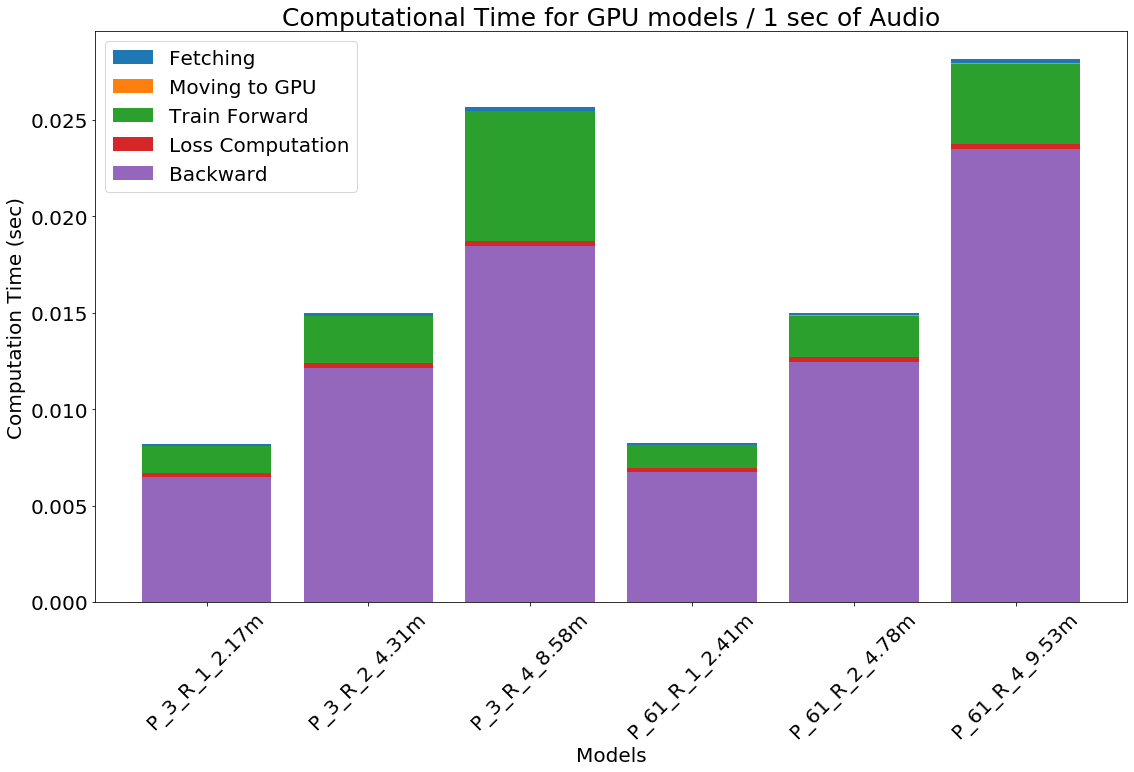

In [33]:
models = sorted([x for x in computational_results if 'True' in x])
metrics = [m for m in computational_results[models[0]] if 'Parameters' not in m and 'Eval' not in m]
parameters = [computational_results[m]['Parameters'] for m in models]

metrics_list = []
for metric in metrics:
    metrics_list.append(np.array([computational_results[x][metric] for x in models]))
ind = [x for x, _ in enumerate(models)]

for i, metric in enumerate(metrics):
    plt.bar(ind, metrics_list[i], label=metric, bottom=sum([y for y in metrics_list[i+1:]]))

plt.yticks(fontsize=20)
plt.xticks(ind, [x[:-len('_GPU_True')] + '_{0:.2f}m'.format(float(parameters[j]) / 10e5)
                 for (j, x) in enumerate(models)], fontsize=20, rotation=45)
plt.ylabel("Computation Time (sec)", fontsize=20)
plt.xlabel("Models", fontsize=20)
plt.legend(loc="best", fontsize=20)
plt.title("Computational Time for GPU models / 1 sec of Audio", fontsize=25)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

plt.show()

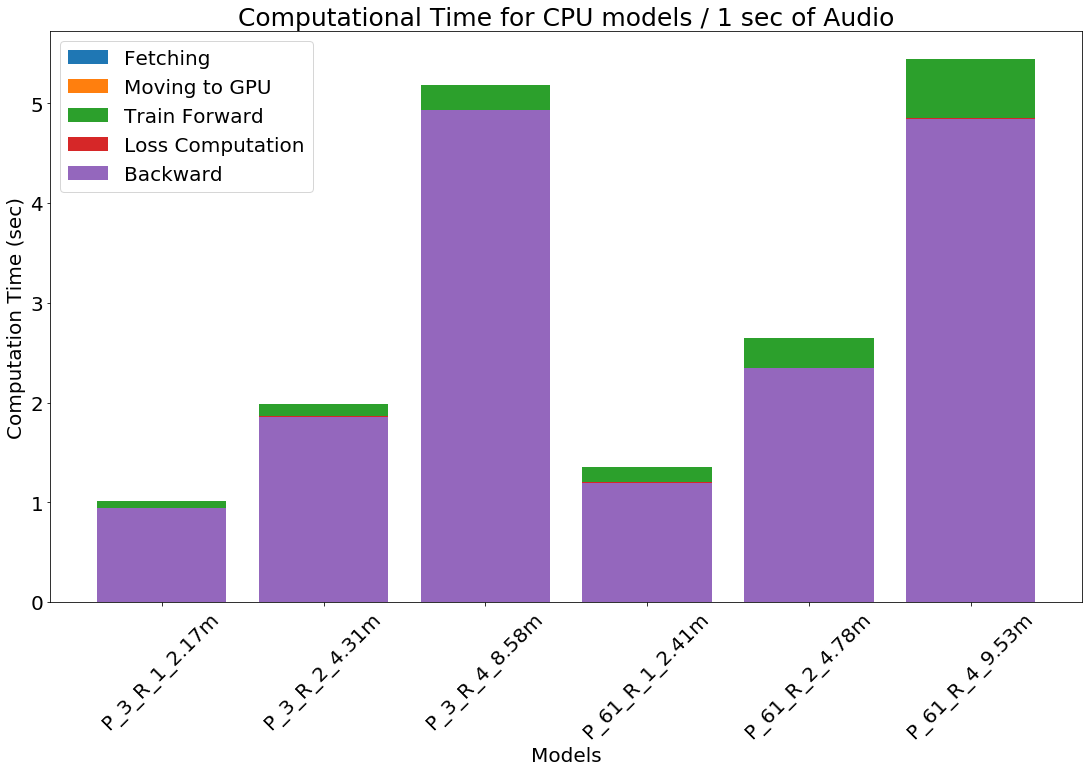

In [32]:
models = sorted([x for x in computational_results if 'False' in x])
metrics = [m for m in computational_results[models[0]] if 'Parameters' not in m and 'Eval' not in m]
parameters = [computational_results[m]['Parameters'] for m in models]

metrics_list = []
for metric in metrics:
    metrics_list.append(np.array([computational_results[x][metric] for x in models]))
ind = [x for x, _ in enumerate(models)]

for i, metric in enumerate(metrics):
    plt.bar(ind, metrics_list[i], label=metric, bottom=sum([y for y in metrics_list[i+1:]]))

plt.yticks(fontsize=20)
plt.xticks(ind, [x[:-len('_GPU_False')] + '_{0:.2f}m'.format(float(parameters[j]) / 10e5)
                 for (j, x) in enumerate(models)], fontsize=20, rotation=45)
plt.ylabel("Computation Time (sec)", fontsize=20)
plt.xlabel("Models", fontsize=20)
plt.legend(loc="best", fontsize=20)
plt.title("Computational Time for CPU models / 1 sec of Audio", fontsize=25)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

plt.show()

Train Forward
[ 49.24657895  52.26843989  37.00135911 127.61186992 138.90749173
 144.590836  ]
Backward
[145.37115594 153.0114144  266.89814965 178.11882428 188.37359375
 206.40246707]


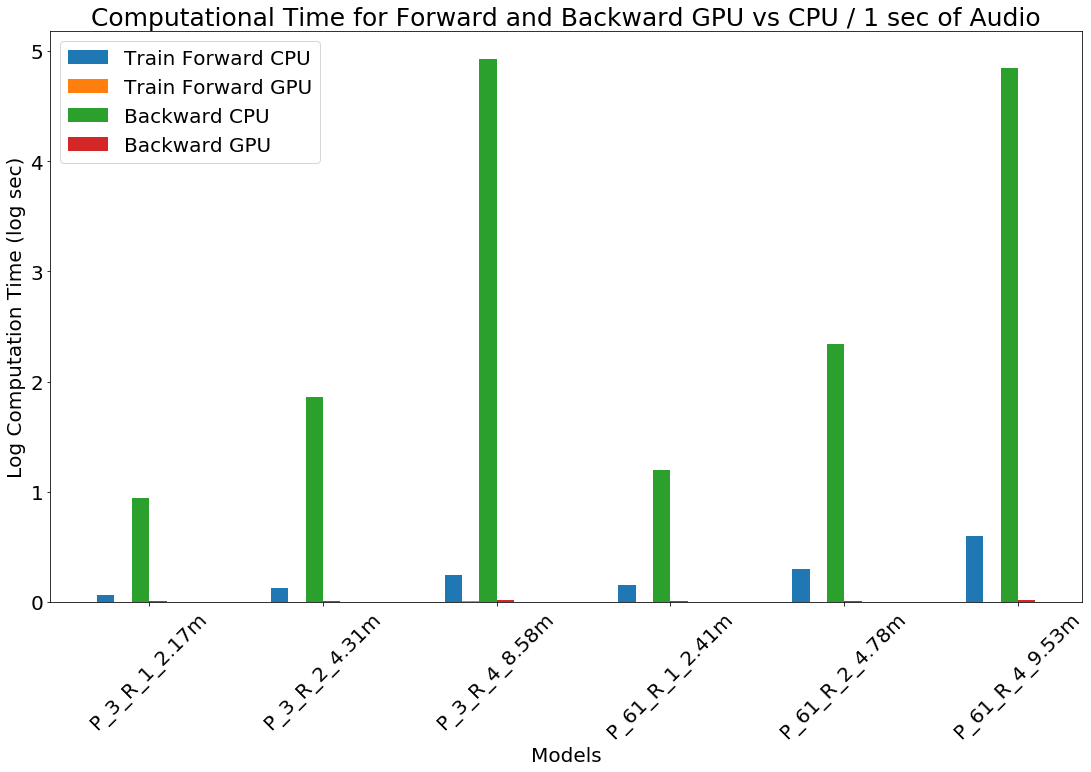

In [99]:
# Do some CPU vs GPU comparisons for the things that we care about
models = sorted([x for x in computational_results if 'False' in x])
trunc_models = [x[:-len('_GPU_False')] for x in models]
metrics = [m for m in computational_results[models[0]]
           if 'Train Forward' in m or 'Backward' in m]
parameters = [computational_results[m]['Parameters'] for m in models]

metrics_list = []
for metric in metrics:
    for to_gpu in ['False', 'True']:
        metrics_list.append(np.array([computational_results[x + '_GPU_{}'.format(to_gpu)][metric]
                                      for x in trunc_models]))
ind = np.array([x for x, _ in enumerate(models)])


barw = 0.1
for i, metric in enumerate(metrics):
    print(metric)
    print(metrics_list[2*i] / metrics_list[2*i + 1])
    plt.bar(ind + (2*i)*barw, metrics_list[2*i], width=barw, label=metric + ' CPU')
    plt.bar(ind + (2*i)*barw + barw, metrics_list[2*i + 1], width=barw, label=metric + ' GPU')

plt.yticks(fontsize=20)
plt.xticks(ind + 2.5*barw, [x[:-len('_GPU_False')] + '_{0:.2f}m'.format(float(parameters[j]) / 10e5)
                 for (j, x) in enumerate(models)], fontsize=20, rotation=45)
plt.ylabel("Log Computation Time (log sec)", fontsize=20)
# plt.xlabel('group', fontweight='bold')
# plt.yscale('log')
plt.xlabel("Models", fontsize=20)
plt.legend(loc="best", fontsize=20)
plt.title("Computational Time for Forward and Backward GPU vs CPU / 1 sec of Audio", fontsize=25)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

plt.show()